Title:  Anomaly Detection In Credit Card Data

Student: Rossella Carone

Numerical Analysis For Machine Learning, a.y.2023/2024

0. Import the libraries

In [ ]:
!pip install ReliefF
!pip install -U Py_FS==0.2.1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from Py_FS.wrapper.population_based.BBA import BBA as FS
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
seed=42
torch.manual_seed(seed)

1. Exploratory Data Analysis

In [ ]:
data = pd.read_csv('creditcard.csv')
data.head()

In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
#check if there are NaN values
nan_values = data.isna().sum()
nan_values

In [ ]:
#check if there any duplication
data.duplicated().sum()

In [ ]:
data.drop_duplicates(data,inplace=True)

In [ ]:
# Dimension
print (f"There are {data.shape[0]} Rows and {data.shape[1]} columns")

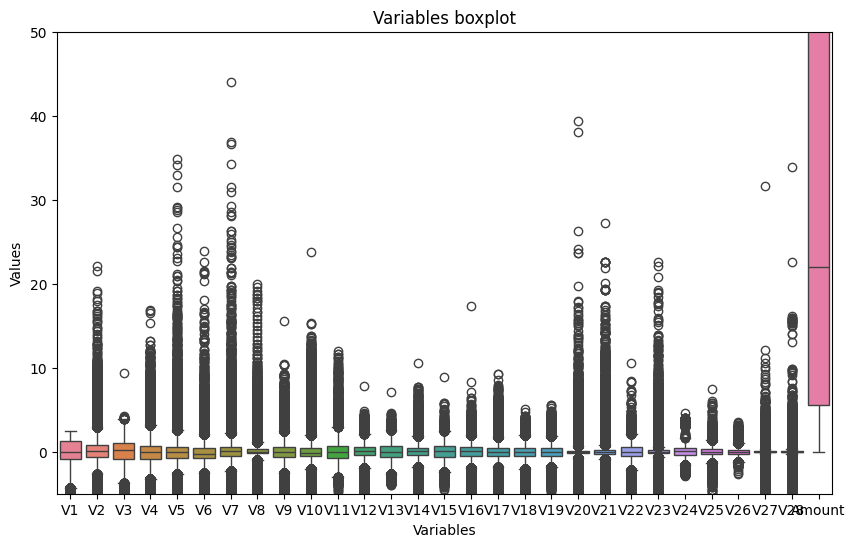

In [ ]:
# Distribution of the features
plt.figure(figsize=(10, 6))
data_plot=data.drop(['Time','Class'], axis=1)
sns.boxplot(data=data_plot)
plt.title('Variables boxplot')
plt.ylim(-5, 50)
plt.ylabel('Values')
plt.xlabel('Variables')
plt.show()

As we can see in the plot, data is highly varied, we need to scale.

I will scale data using Standard Scaler after the split into training and test set.

In [ ]:
#Target distribution
fraud = (data['Class'] == 1).sum()
no_fraud = (data['Class'] == 0).sum()
tot=fraud + no_fraud
print("%d fraudulent credit card transactions out of %d" % (fraud, tot))

473 fraudulent credit card transactions out of 283726


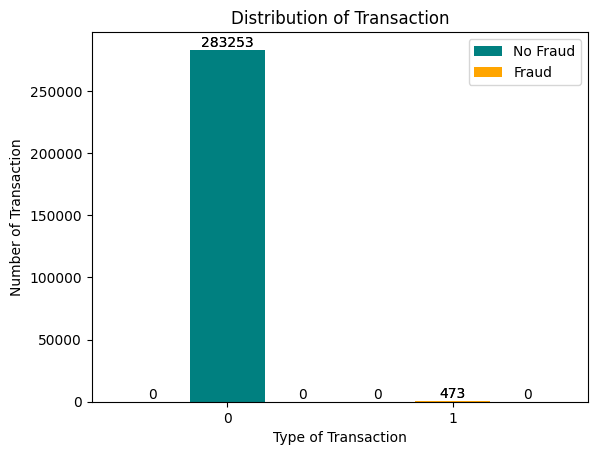

In [ ]:
ax = sns.countplot(data = data, x = "Class", width = 0.3)
ax.hist(data[data['Class'] == 0]['Class'], bins=3, color='teal', label='No Fraud')
ax.hist(data[data['Class'] == 1]['Class'], bins=3, color='orange', label='Fraud')
ax.set_title("Distribution of Transaction")
plt.xlabel("Type of Transaction")
plt.ylabel("Number of Transaction")
for i in ax.containers:
    ax.bar_label(i)
plt.legend()
plt.show()

As we can see in the histogram, the dataset is highly unbalanced.

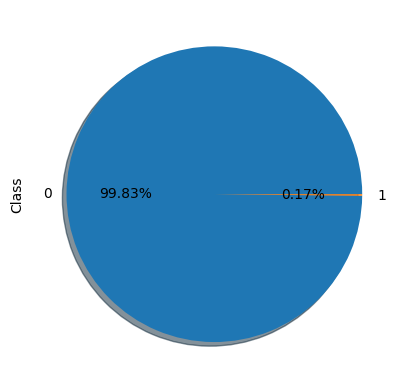

In [ ]:
# Another type of visualization
data["Class"].value_counts().plot(kind= "pie",autopct='%1.2f%%', shadow = True)
plt.show()

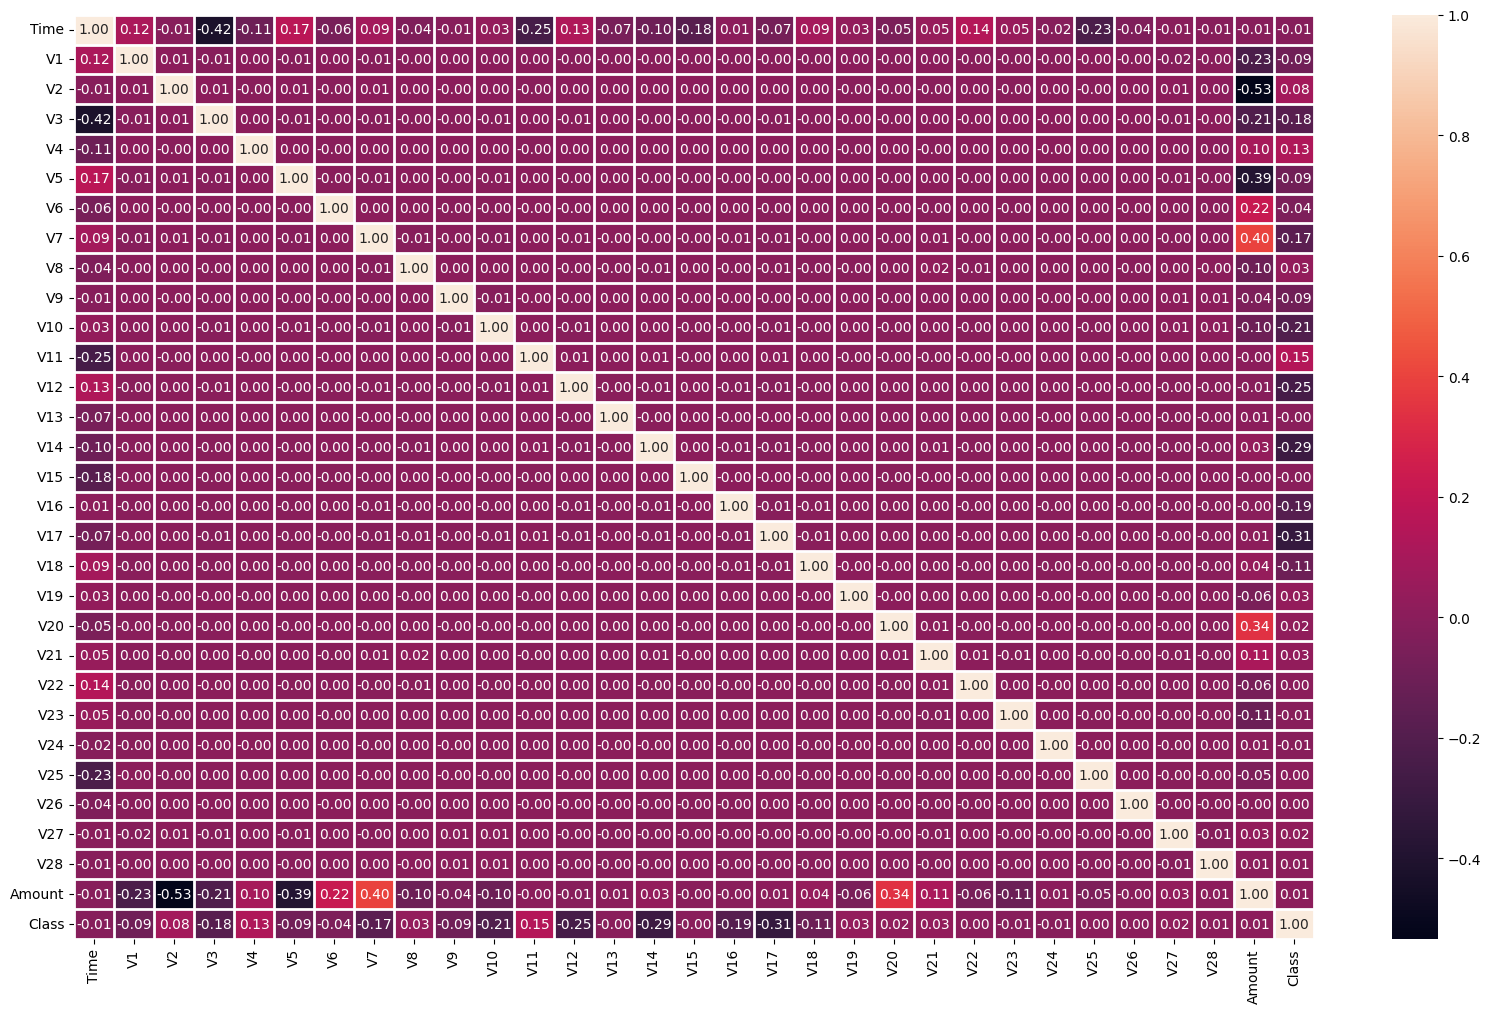

In [ ]:
# Correlation among the features
plt.figure(figsize = (20, 12))
ax = sns.heatmap(data.corr(), annot = True, fmt = '.2f')
for i in range(data.shape[1] + 1):
    ax.axvline(i, color='white', lw = 2)
    ax.axhline(i, color='white', lw = 2)
plt.show()

Negative Correlations: the lower these values are, the more likely the end result will be a fraud transaction.

Positive Correlations: the higher these values are, the more likely the end result will be a fraud transaction.

2. Balancing data

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=seed)
X= data.loc[:, 'Time':'Amount']
y=data['Class']
X, y = smote.fit_resample(X, y)
y_array= np.expand_dims(y.to_numpy(), axis=1)
df=np.concatenate((X, y_array), axis=1)
df = pd.DataFrame(df, columns=['Time'] + [f'V{i}' for i in range(1, 29)] +['Amount']+ ['Class'])
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [ ]:
fraud = (df['Class'] == 1).sum()
no_fraud = (df['Class'] == 0).sum()
tot=fraud + no_fraud
print("%d fraudulent credit card transactions out of %d" % (fraud, tot))

283253 fraudulent credit card transactions out of 566506


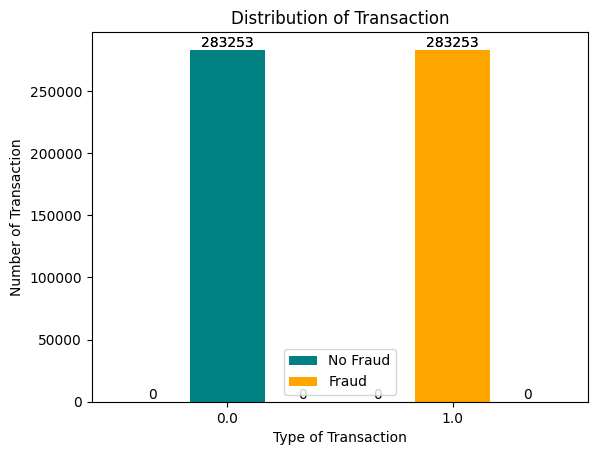

In [ ]:
ax = sns.countplot(data = df, x = "Class", width = 0.3)
ax.hist(df[df['Class'] == 0]['Class'], bins=3, color='teal', label='No Fraud')
ax.hist(df[df['Class'] == 1]['Class'], bins=3, color='orange', label='Fraud')
ax.set_title("Distribution of Transaction")
plt.xlabel("Type of Transaction")
plt.ylabel("Number of Transaction")
for i in ax.containers:
    ax.bar_label(i)
plt.legend()
plt.show()

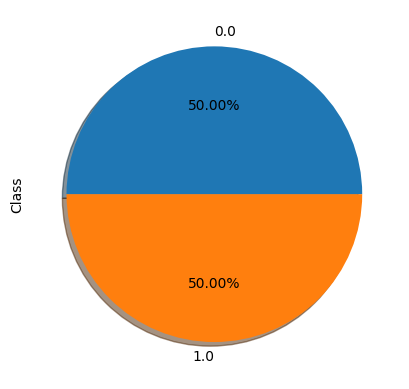

In [ ]:
df["Class"].value_counts().plot(kind= "pie",autopct='%1.2f%%', shadow = True)
plt.show()

3. Split into training, validation and test set:

- 70% data: TRAINING SET

- 15% data: VALIDATION SET

- 15% data: TEST SET

In [ ]:
X_train, X_combined, y_train, y_combined = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_combined, y_combined, test_size=0.5, random_state=seed)

4. Normalization

In [ ]:
# Normalization
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_val_scaled=scaler.fit_transform(X_val)
X_test_scaled=scaler.fit_transform(X_test)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

5. Feature selection - BAT Optimization Algorithm

Values for the algorithm:

Min Frequency (default=0): 0

Max Frequency (default=2): 1

Loudness (default=1.0): 1

Pulse emission rate (default=0.15): 0.15

Alpha value [0-1] (default=0.95): 0.90

Gamma value [0-1] (default=0.5): 0.90

Othere parameters are set to their default values

In [ ]:
start_time = time.time()
algo = FS(num_agents=25, max_iter=20, train_data=X_val, train_label=y_val, save_conv_graph=True)
results = algo.run()
end_time = time.time()
execution_time = end_time - start_time
print("Execution time of Bat Algorithm:", execution_time, "seconds")

In [ ]:
print(results.solution.best_agent)
col_indices=results.solution.best_agent
n_features=sum(results.solution.best_agent).astype(int)
print("The number of selected features is:", n_features)

In [ ]:
#To not run again the algorithm
#col_indices = np.array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,0., 0., 0., 0., 0., 0.])
#n_features = 5

In [ ]:
X_train= X_train.iloc[:, col_indices.nonzero()[0]]
X_val= X_val.iloc[:, col_indices.nonzero()[0]]
X_test= X_test.iloc[:, col_indices.nonzero()[0]]

6. FCL Function

6.1 DCL Function

In [ ]:
class DCL(nn.Module):
    """Distance loss.

    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes, deep_representation_size):

        # Defining the loss as a class, to better perform the computation.
        # Deep representation size corresponds to the dimension of f_i, the embeddings.
        super(DCL, self).__init__()
        self.num_classes = num_classes
        self.input_size = deep_representation_size
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.input_size, dtype=torch.float64))

    def forward(self, x, labels):
        """
        Args:
            x: deep representation batch of size (batch_size, deep_representation_size).
            labels: ground truth labels with shape (batch_size).
        """

        # Computing the euclidean distance w.r.t. the correct label and its centroid.
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        # Considering the distance corresponding to the correct label
        classes = torch.arange(self.num_classes).long()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))
        dist = distmat * mask.float()
        dcl_loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return dcl_loss

6.2 ACL Function

In [ ]:
class ACL(nn.Module):
    """Angle Center loss.

    Assumption: no offset and opposite matrices.

    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """

    def __init__(self, deep_representation_size):

        super(ACL, self).__init__()

        # We are assuming to have two classes
        # Therefore we only define W as a vector

        # We assume self.W stands for W_0. W_1 = - W_0
        self.W = nn.Parameter(torch.randn(deep_representation_size, dtype=torch.float64))


    def forward(self, x, labels):
        """
        Args:
            x: deep_representation batch of size (batch_size, deep_representation).
            labels: ground truth labels with shape (batch_size).
        """
        acl_loss = torch.sum(torch.log(1 + torch.exp( (-1)**labels * torch.matmul(x,self.W) )))

        return acl_loss

7. Model

In [ ]:
class Model(nn.Module):
    def __init__(self,input_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, 32, dtype=torch.float64)
        self.fc2 = nn.Linear(32, 64, dtype=torch.float64)
        self.fc3 = nn.Linear(64, 16, dtype=torch.float64)
        self.fc4 = nn.Linear(16, 8, dtype=torch.float64)
        self.fc5 = nn.Linear(8, 1, dtype=torch.float64)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        fi = self.activation(self.fc4(x))
        output = self.sigmoid(self.fc5(fi))
        return fi, torch.ravel(output)

# Defining useful variables
model_input_size = n_features
deep_representation_size = 8

# Set the number of epochs
n_epochs = 5

# Set the batch size
batch_size = 128

#How to define the model, losses, parameters and optimizer:

# Creating the model object
model = Model(model_input_size)

# Creating the loss functions
dcl_loss = DCL(2,deep_representation_size)
acl_loss = ACL(deep_representation_size)
binary_loss = nn.BCELoss()

# Define the parameters
params = list(model.parameters()) + list(dcl_loss.parameters()) + list(acl_loss.parameters())

# Define the optimizer
optimizer = torch.optim.SGD(params, lr=0.1)


Defining a CustomerDataset, to be able to give the observations to the PyTorch DataLoader

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X.iloc[idx,:].values, self.y.iloc[idx]

In [ ]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model,
                       acl_loss, dcl_loss, binary_loss, alpha, beta, optimizer, n_epochs,batch_size):

  training_dataset = CustomDataset(X_train,y_train)
  train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

  for epoch in range(n_epochs):
    for feature, label in tqdm(train_dataloader, total=len(train_dataloader)):

            optimizer.zero_grad()
            fi,output = model(feature)
            fcl_loss = acl_loss(fi,label) + alpha * dcl_loss(fi, label)
            b_loss=binary_loss(output,label.double())
            loss= beta*fcl_loss + b_loss
            loss.backward()
            optimizer.step()

  test_dataset = CustomDataset(X_test, y_test)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
  all_predictions = []
  all_labels = []

  with torch.no_grad():
        for data, labels in tqdm(test_dataloader, total=len(test_dataloader)):
            features, outputs = model(data)
            predictions = torch.round(outputs)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

  accuracy = accuracy_score(all_labels, all_predictions)
  precision = precision_score(all_labels, all_predictions)
  recall = recall_score(all_labels, all_predictions)
  f1 = f1_score(all_labels, all_predictions)
  auc = roc_auc_score(all_labels, all_predictions)

  return accuracy, precision, recall, f1, auc, all_labels, all_predictions

8. Hyperparameters setting through grid search method

   We need to find the optimal value for:

 - Learning rate
 - Weight of DCL Function (alpha)
 - Weight of FCL Function (beta)


In [ ]:
param_grid = {
    'lr': [0.1, 0.05, 0.01],
    'alpha': [0.2, 0.15, 0.10],
    'beta': [0.15, 0.1, 0.05],
}

results = []
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

for par in ParameterGrid(param_grid):

  lr=par['lr']
  alpha=par['alpha']
  beta=par['beta']
  accuracy = 0

  for train_index, test_index in kf.split(X_val):
      X_train_fold, X_test_fold = X_val.iloc[train_index,:], X_val.iloc[test_index,:]
      y_train_fold, y_test_fold = y_val.iloc[train_index], y_val.iloc[test_index]
      model = Model(model_input_size)
      dcl_loss = DCL(2,deep_representation_size)
      acl_loss = ACL(deep_representation_size)
      binary_loss = nn.BCELoss()
      params = list(model.parameters()) + list(dcl_loss.parameters()) + list(acl_loss.parameters())
      optimizer = torch.optim.SGD(params, lr=lr)
      acc = train_and_evaluate(X_train_fold, y_train_fold, X_test_fold, y_test_fold, model,
                       acl_loss, dcl_loss, binary_loss, alpha, beta, optimizer, n_epochs, batch_size)[0]
      accuracy += acc
  accuracy /= k_folds
  results.append({
        'parameters': par,
        'accuracy': accuracy,
      })


best_result = max(results, key=lambda x: x['accuracy'])
best_params = best_result['parameters']
best_accuracy = best_result['accuracy']
print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)


100%|██████████| 133/133 [00:02<00:00, 61.83it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 133/133 [00:01<00:00, 94.43it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 133/133 [00:01<00:00, 98.28it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

Best parameters: {'alpha': 0.1, 'beta': 0.15, 'lr': 0.05}
Best accuracy: 0.970450498675735


9. Train and test the model

In [ ]:
# Hyperparameters
lr=best_params['lr']
alpha=best_params['alpha']
beta=best_params['beta']

In [ ]:
#To not run again the algorithm:
#lr=0.05
#alpha=0.1
#beta=0.15

In [ ]:
model = Model(model_input_size)
dcl_loss = DCL(2,deep_representation_size)
acl_loss = ACL(deep_representation_size)
binary_loss = nn.BCELoss()
params = list(model.parameters()) + list(dcl_loss.parameters()) + list(acl_loss.parameters())
optimizer = torch.optim.SGD(params, lr=lr)

In [ ]:
accuracy, precision, recall, f1, auc, all_labels, all_predictions = train_and_evaluate(X_train, y_train, X_test, y_test, model,
                       acl_loss, dcl_loss, binary_loss, alpha, beta, optimizer, n_epochs, batch_size)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC:", auc)

100%|██████████| 664/664 [00:08<00:00, 78.35it/s]


Accuracy: 0.9830305027301827
Precision: 0.9868289667633493
Recall: 0.979054627795075
F1 Score: 0.9829264249686234
AUC: 0.9830219123005437


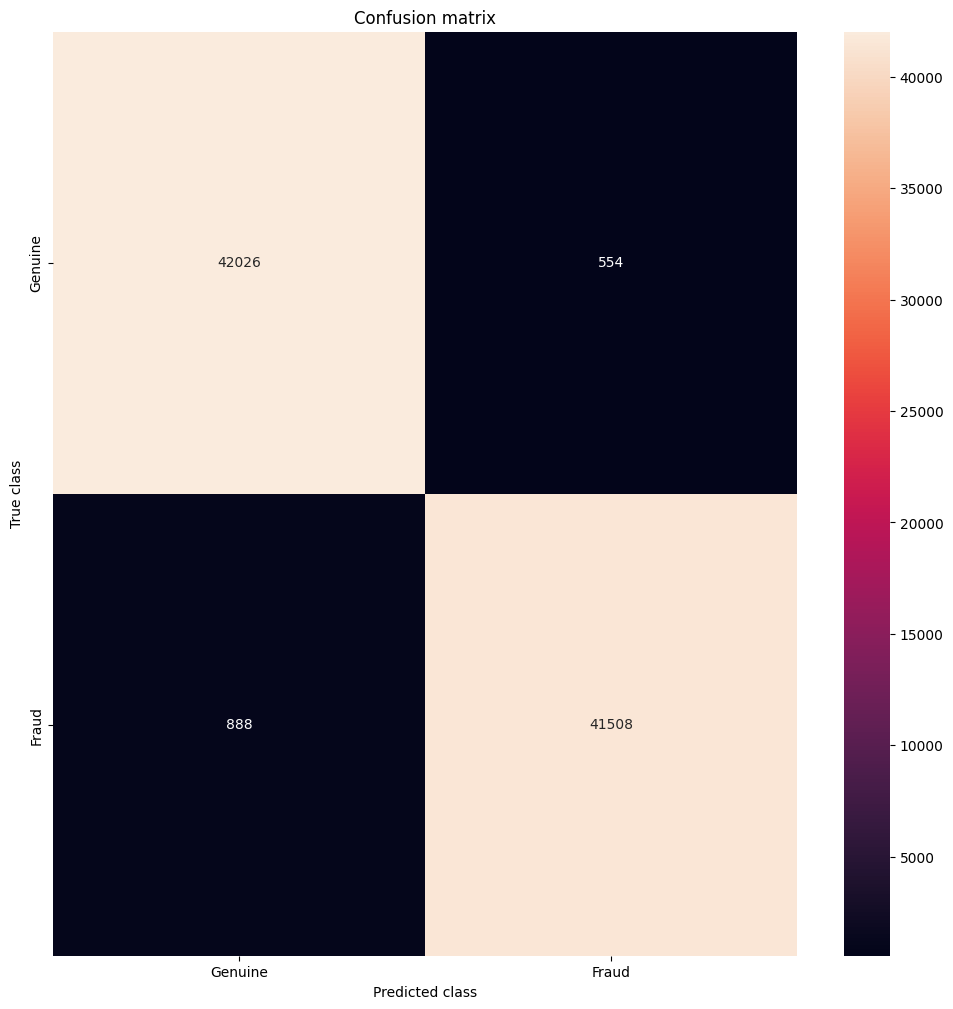

In [ ]:
LABELS = ['Genuine', 'Fraud']
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize =(12, 12))
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()